<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Все-функции" data-toc-modified-id="Все-функции-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Все функции</a></span><ul class="toc-item"><li><span><a href="#Функции-перевода-изображения-в-монохромный-формат." data-toc-modified-id="Функции-перевода-изображения-в-монохромный-формат.-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Функции перевода изображения в монохромный формат.</a></span></li><li><span><a href="#Функции-resize-и-warp" data-toc-modified-id="Функции-resize-и-warp-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Функции resize и warp</a></span></li><li><span><a href="#Функции-рисования-изображений" data-toc-modified-id="Функции-рисования-изображений-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Функции рисования изображений</a></span></li></ul></li><li><span><a href="#Использование-функции-warp" data-toc-modified-id="Использование-функции-warp-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Использование функции warp</a></span><ul class="toc-item"><li><span><a href="#Круговой-(центрированный)-warp" data-toc-modified-id="Круговой-(центрированный)-warp-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Круговой (центрированный) warp</a></span><ul class="toc-item"><li><span><a href="#Вычитаем-один-круговой-warp-из-другого-для-разных-параметров" data-toc-modified-id="Вычитаем-один-круговой-warp-из-другого-для-разных-параметров-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Вычитаем один круговой warp из другого для разных параметров</a></span><ul class="toc-item"><li><span><a href="#Увеличиваем-distance_coef-и-shift" data-toc-modified-id="Увеличиваем-distance_coef-и-shift-2.1.1.1"><span class="toc-item-num">2.1.1.1&nbsp;&nbsp;</span>Увеличиваем <code>distance_coef</code> и <code>shift</code></a></span></li><li><span><a href="#Меняем-время--time" data-toc-modified-id="Меняем-время--time-2.1.1.2"><span class="toc-item-num">2.1.1.2&nbsp;&nbsp;</span>Меняем время  <code>time</code></a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Монохромные-варианты-warp" data-toc-modified-id="Монохромные-варианты-warp-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Монохромные варианты warp</a></span></li></ul></div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time as tm

from skimage import io, color, img_as_float
from scipy.ndimage import map_coordinates
import cv2 


# Все функции

## Функции перевода изображения в монохромный формат. 
А также функции умножения матрицы на транспонированную и различных нормализаций. 
Вдруг понадобятся ;-) 

In [2]:
t1_itogo = tm.time()


def monochrome(rgb_image):
    coeffs = np.array([0.299, 0.587, 0.114]) #!!! Не переводим элементы вектора в формат unit8
    return rgb_image @ coeffs


def resize_and_monochrome (picture, k):
    new_size = (round(picture.shape[1]/k), round(picture.shape[0]/k))
    picture = cv2.resize(picture, new_size, interpolation=cv2.INTER_AREA)
    picture_monochrome = monochrome(picture)
    return picture, picture_monochrome



In [3]:
def normalize_image(im):   
    im_res = im - np.min(im)
    return (1 / np.max(im_res)) * im_res

def norm_columns(x):
    columns_sums = np.sum(x, axis=0)
    columns_sums[columns_sums == 0] = np.finfo(float).eps
    # Убедимся, что нормализация применяется корректно
    return x / columns_sums[np.newaxis, :]

# поправила norm_rows, а то там появляется деление на ноль
def norm_rows(x):
    row_sums = np.sum(x, axis=1)
    # Замена нулей на очень маленькое число, чтобы избежать деления на ноль
    row_sums[row_sums == 0] = np.finfo(float).eps
    return x / row_sums[:, np.newaxis]


def trans_mult(A):
    result = normalize_image(np.dot(monochrome(A), np.transpose(monochrome(A))))
    return result

def trans_mult_norm(A):
    result = normalize_image(np.dot(norm_rows(monochrome(A)), norm_columns(np.transpose(monochrome(A)))))
    return result

def trans_mult_norm_plus_1(A):
    B = A+1
    result = normalize_image(np.dot(norm_rows(monochrome(B)), norm_columns(np.transpose(monochrome(B)))))
    return result

def normalize_image_signed(img):
    img1 = img - np.min(img)
    img2 = (2 / np.max(img1)) * img1
    return img2 - 1


def trans_mult_signed(A):
    B = normalize_image_signed(monochrome(A))
    result = normalize_image(np.dot(B, np.transpose(B)))
    return result

## Функции resize и warp

In [4]:
# круговой warp без динамического преобразования
# работает и с монохромным и с цветным изображением


def warp_func_centered(x, y, xcenter, ycenter, distance_coef, time, shift):
    distance = np.sqrt((xcenter - x) ** 2 + (ycenter - y) ** 2)
    mod_ = 0.25 * np.sin(distance_coef * (distance / (time + shift + 0.1))) + 0.75
    
    def g(center, coord):
        return center + (coord - center) * mod_
    
    xnew = g(xcenter, x)
    ynew = g(ycenter, y)
    
    return xnew, ynew


def apply_warp_centered(warp_func, A, xcenter, ycenter, distance_coef, time, shift):
    if A.ndim == 3: # Проверка, является ли изображение цветным
        xsize, ysize, channels = A.shape
    else:
        xsize, ysize = A.shape
        channels = 1

    result = np.zeros_like(A)

    for channel in range(channels) if channels > 1 else [0]:
        for x in range(xsize):
            for y in range(ysize):
                xnew, ynew = warp_func(x + 1, y + 1, xcenter, ycenter, distance_coef, time, shift)
                xnew = int(np.floor(xnew)) - 1
                ynew = int(np.floor(ynew)) - 1
                
                if 0 <= xnew < xsize and 0 <= ynew < ysize:
                    if channels > 1:
                        result[x, y, channel] = A[xnew, ynew, channel]
                    else:
                        result[x, y] = A[xnew, ynew]

    return result


## Функции рисования изображений

In [5]:
# сделаем рисование трех картинок конкретной выбранной функцией warp
# непонятно, получится ли, потому что у кругового wrap другиме параметры. Возможно придется переписывать, 
# а picture_warp можно будет использовать для вертикального и горизонтального warp

def wrap_text(text, max_length):
   
    if len(text) <= max_length:
        return text
    # Находим пробел ближайший к середине строки для красивого переноса
    split_points = [i for i, char in enumerate(text) if char == ' ']
    best_split = min(split_points, key=lambda x: abs(x - max_length))
    return text[:best_split] + '\n' + wrap_text(text[best_split+1:], max_length)


def picture_warp (kind_warp, warp_name, knob, A, B, C, A_name, B_name, C_name):
   
    
    fig, axes = plt.subplots(2, 3, figsize=(16, 14))
    plt.subplots_adjust(hspace=0.3)
    axes[0,0].imshow(A, cmap='gray')
    axes[0,0].set_title(A_name)
# Включение сетки
    axes[0,0].grid(True, which='both', color='green', linestyle='-', linewidth=0.5)

    axes[0,1].imshow(B, cmap='gray')
    axes[0,1].set_title(B_name)
# Включение сетки
    axes[0,1].grid(True, which='both', color='green', linestyle='-', linewidth=0.5)

    axes[0,2].imshow(C, cmap='gray')
    axes[0,2].set_title(C_name)
# Включение сетки
    axes[0,2].grid(True, which='both', color='green', linestyle='-', linewidth=0.5)

    fig.text(0.5, 0.5, f'Pictures after {warp_name}\n', 
         ha='center', va='center', fontsize=15)

    
    axes[1,0].imshow(apply_warp(kind_warp, A, knob), cmap='gray')
    axes[1,0].set_title(wrap_text(f'{A_name} after \n{warp_name}', 45))
# Включение сетки
    axes[1,0].grid(True, which='both', color='green', linestyle='-', linewidth=0.5)


    
    axes[1,1].imshow(apply_warp(kind_warp, B, knob), cmap='gray')
    axes[1,1].set_title(wrap_text(f'{B_name} after \n{warp_name}', 45))
    axes[1,1].grid(True, which='both', color='green', linestyle='-', linewidth=0.5)

    axes[1,2].imshow(apply_warp(kind_warp, C, knob), cmap='gray')
    axes[1,2].set_title(wrap_text(f'{C_name} after \n{warp_name}', 45))

    axes[1,2].grid(True, which='both', color='green', linestyle='-', linewidth=0.5)
    
    # Отображение фигуры с подграфиками
    plt.show()



# Использование функции warp

## Круговой (центрированный) warp

максимальный размер стороны картинки parrot 472


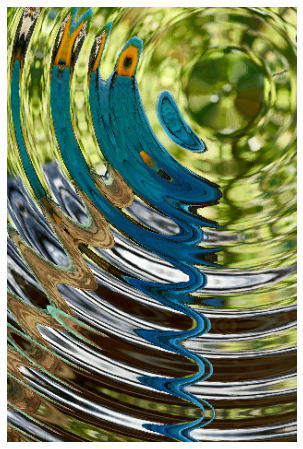

CPU times: total: 4.06 s
Wall time: 5.85 s


In [6]:
%%time
import time
# проверим отдельно warp  для одной цветной  картинки
t1 = time.time()

parrot_raw = io.imread('https://images.unsplash.com/photo-1534567059665-cbcfe2e73b91?q=80&w=1887&auto=format&fit=crop&ixlib='
                   'rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D')

parrot_raw, parrot = resize_and_monochrome (parrot_raw, 6)

print('максимальный размер стороны картинки parrot', max(parrot.shape[0], parrot.shape[1]))

xcenter = 0.3 * parrot.shape[1]
ycenter = 0.5 * parrot.shape[0]
distance_coef = 0.8  # Примерное значение для частоты волн
shift = 5 
time_1 = 1 # Сдвиг волн



plt.figure(figsize=(10, 8))

plt.imshow(apply_warp_centered(warp_func_centered, parrot_raw, xcenter, ycenter, distance_coef, time_1, shift))
plt.axis('off')

plt.show()

In [7]:
t2 = time.time()
print("Одна картинка нарисовалась за ", t2 - t1, " seconds")
# t1 и t2 я сделала для того, чтобы проверить, что %%time для Питона нормально работает

Одна картинка нарисовалась за  5.897400617599487  seconds


максимальный размер стороны картинки parrot 472


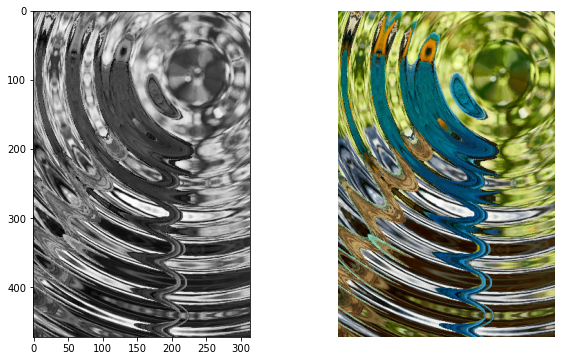

CPU times: total: 6.25 s
Wall time: 7.37 s


In [8]:
%%time

# проверяем, что функция центрального warp правильно работает и на монохрормных, и на цветных картинках

parrot_raw = io.imread('https://images.unsplash.com/photo-1534567059665-cbcfe2e73b91?q=80&w=1887&auto=format&fit=crop&ixlib='
                   'rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D')

parrot_raw, parrot = resize_and_monochrome (parrot_raw, 6)

print('максимальный размер стороны картинки parrot', max(parrot.shape[0], parrot.shape[1]))

xcenter = 0.3 * parrot.shape[1]
ycenter = 0.5 * parrot.shape[0]
distance_coef = 0.8  # Примерное значение для частоты волн
shift = 5 
time = 1 # Сдвиг волн

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].imshow(apply_warp_centered(warp_func_centered, parrot, xcenter, ycenter, distance_coef, time, shift),cmap = 'gray')
plt.axis('off')

axes[1].imshow(apply_warp_centered(warp_func_centered, parrot_raw, xcenter, ycenter, distance_coef, time, shift))
plt.axis('off')

plt.show()

максимальный размер стороны картинки yellow 444


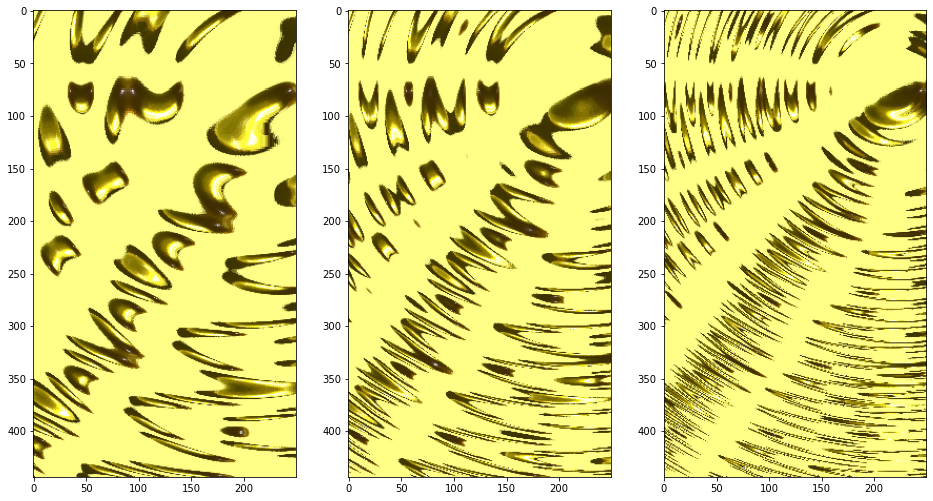

CPU times: total: 10.2 s
Wall time: 12.3 s


In [9]:
%%time

yellow_raw = io.imread('https://images.unsplash.com/photo-1623066542605-bc25b4b662dd?w=500&auto=format&fit=crop&q=60&ixlib=rb-4.0.3'
                   '&ixid=M3wxMjA3fDB8MHx0b3BpYy1mZWVkfDI4fGlVSXNuVnRqQjBZfHxlbnwwfHx8fHw%3D')


yellow_raw, yellow = resize_and_monochrome (yellow_raw, 2)

xcenter = 0.3 * yellow.shape[1]
ycenter = 0.5 * yellow.shape[0]
distance_coef = 0.5  # Примерное значение для частоты волн
shift = 5 
time = 1 # Сдвиг волн

print('максимальный размер стороны картинки yellow', max(yellow.shape[0], yellow.shape[1]))


fig, axes = plt.subplots(1, 3, figsize=(16, 14))
axes[0].imshow(apply_warp_centered(warp_func_centered, yellow_raw, xcenter, ycenter, 
                                             distance_coef, time, shift), cmap='gray')
    

    
axes[1].imshow(apply_warp_centered(warp_func_centered, yellow_raw, xcenter, ycenter, 
                                             distance_coef*2, time, shift), cmap='gray')
   

axes[2].imshow(apply_warp_centered(warp_func_centered, yellow_raw, xcenter, ycenter, 
                                             distance_coef*4, time, shift), cmap='gray')
    
plt.show()

максимальный размер стороны картинки parrot 472


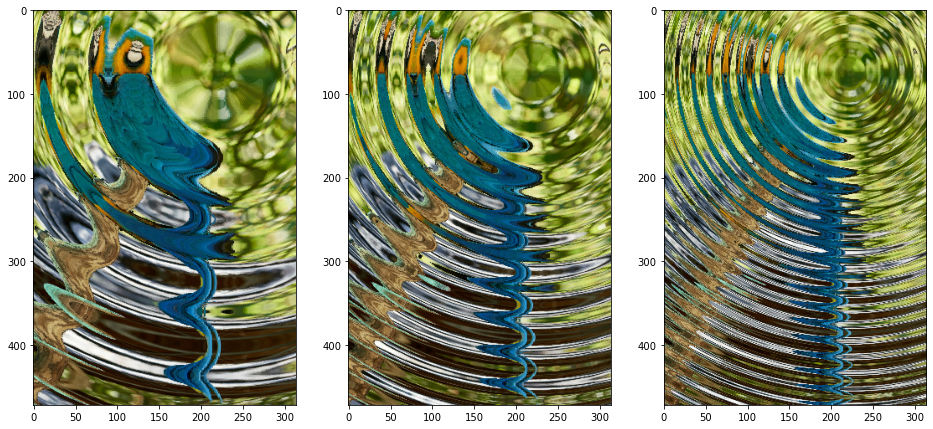

CPU times: total: 14.2 s
Wall time: 15 s


In [10]:
%%time

parrot_raw = io.imread('https://images.unsplash.com/photo-1534567059665-cbcfe2e73b91?q=80&w=1887&auto=format&fit=crop&ixlib='
                   'rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D')

parrot_raw, parrot = resize_and_monochrome (parrot_raw, 6)

xcenter = 0.3 * yellow.shape[1]
ycenter = 0.5 * yellow.shape[0]
distance_coef = 0.5  # Примерное значение для частоты волн
shift = 5 
time = 1 # Сдвиг волн


print('максимальный размер стороны картинки parrot', max(parrot.shape[0], parrot.shape[1]))

fig, axes = plt.subplots(1, 3, figsize=(16, 14))
axes[0].imshow(apply_warp_centered(warp_func_centered, parrot_raw, xcenter, ycenter, 
                                             distance_coef, time, shift), cmap='gray')
    

    
axes[1].imshow(apply_warp_centered(warp_func_centered, parrot_raw, xcenter, ycenter, 
                                             distance_coef*2, time, shift), cmap='gray')
   

axes[2].imshow(apply_warp_centered(warp_func_centered, parrot_raw, xcenter, ycenter, 
                                             distance_coef*4, time, shift), cmap='gray')
    
plt.show()

максимальный размер стороны картинки parrot 472


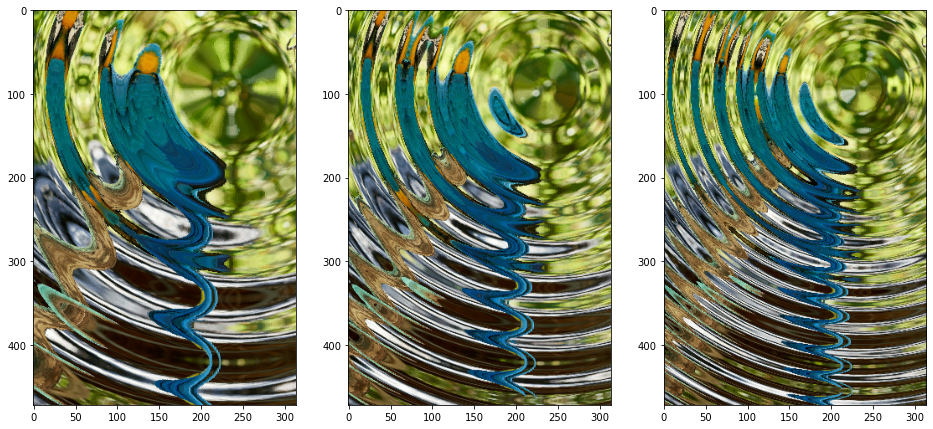

CPU times: total: 14.4 s
Wall time: 15.6 s


In [11]:
%%time

parrot_raw = io.imread('https://images.unsplash.com/photo-1534567059665-cbcfe2e73b91?q=80&w=1887&auto=format&fit=crop&ixlib='
                   'rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D')

parrot_raw, parrot = resize_and_monochrome (parrot_raw, 6)


xcenter = 0.3 * parrot.shape[1]
ycenter = 0.5 * parrot.shape[0]
distance_coef = 0.5  # Примерное значение для частоты волн
shift = 5 
time = 1 # Сдвиг волн

print('максимальный размер стороны картинки parrot', max(parrot.shape[0], parrot.shape[1]))


fig, axes = plt.subplots(1, 3, figsize=(16, 14))
axes[0].imshow(apply_warp_centered(warp_func_centered, parrot_raw, xcenter, ycenter, 
                                             distance_coef, time, shift), cmap='gray')
    

    
axes[1].imshow(apply_warp_centered(warp_func_centered, parrot_raw, xcenter, ycenter, 
                                             distance_coef, time, shift/2), cmap='gray')
   

axes[2].imshow(apply_warp_centered(warp_func_centered, parrot_raw, xcenter, ycenter, 
                                             distance_coef, time, shift/4), cmap='gray')
    
plt.show()

максимальный размер стороны картинки parrot 472


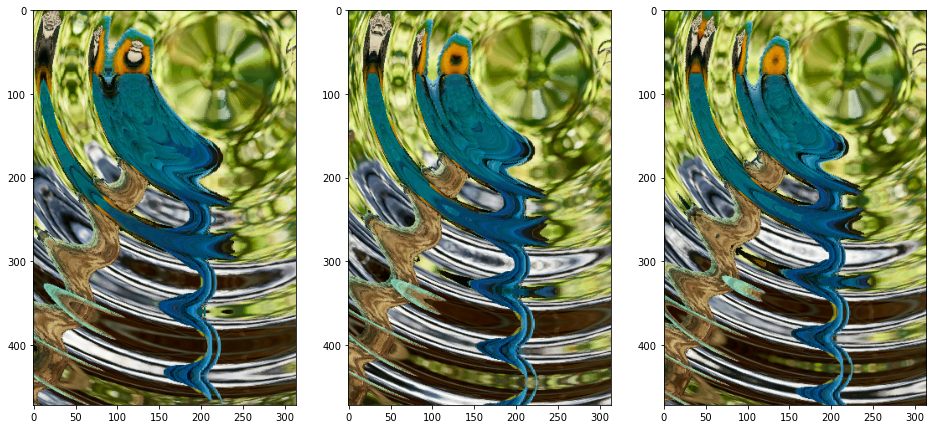

CPU times: total: 14.3 s
Wall time: 15.1 s


In [12]:
%%time

parrot_raw = io.imread('https://images.unsplash.com/photo-1534567059665-cbcfe2e73b91?q=80&w=1887&auto=format&fit=crop&ixlib='
                   'rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D')

parrot_raw, parrot = resize_and_monochrome (parrot_raw, 6)

xcenter = 0.3 * yellow.shape[1]
ycenter = 0.5 * yellow.shape[0]
distance_coef = 0.5  # Примерное значение для частоты волн
shift = 5 
time = 1 # Сдвиг волн

print('максимальный размер стороны картинки parrot', max(parrot.shape[0], parrot.shape[1]))

fig, axes = plt.subplots(1, 3, figsize=(16, 14))
axes[0].imshow(apply_warp_centered(warp_func_centered, parrot_raw, xcenter, ycenter, 
                                             distance_coef, time, shift), cmap='gray')
    

    
axes[1].imshow(apply_warp_centered(warp_func_centered, parrot_raw, xcenter, ycenter, 
                                             distance_coef, time/2, shift), cmap='gray')
   

axes[2].imshow(apply_warp_centered(warp_func_centered, parrot_raw, xcenter, ycenter, 
                                             distance_coef, time/4, shift), cmap='gray')
    
plt.show()

### Вычитаем один круговой warp из другого для разных параметров

#### Увеличиваем `distance_coef` и `shift`

максимальный размер стороны картинки parrot 472


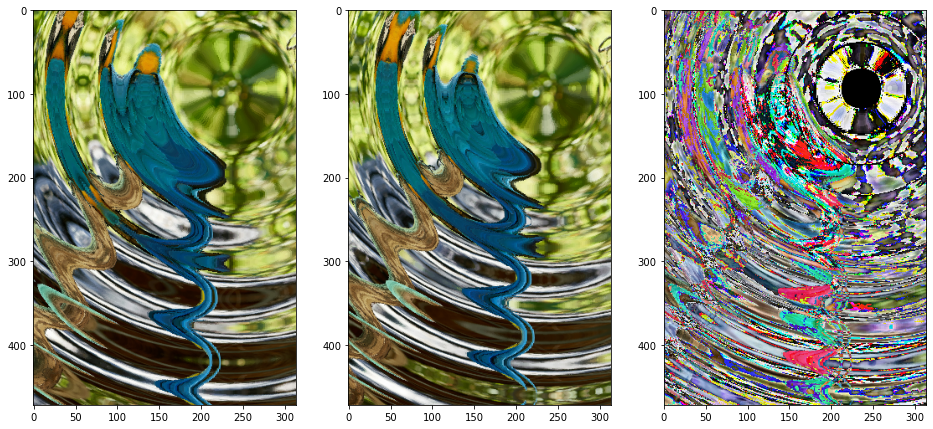

CPU times: total: 8.5 s
Wall time: 9.15 s


In [13]:
%%time

parrot_raw = io.imread('https://images.unsplash.com/photo-1534567059665-cbcfe2e73b91?q=80&w=1887&auto=format&fit=crop&ixlib='
                   'rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D')

parrot_raw, parrot = resize_and_monochrome (parrot_raw, 6)

print('максимальный размер стороны картинки parrot', max(parrot.shape[0], parrot.shape[1]))


xcenter = 0.3 * parrot.shape[1]
ycenter = 0.5 * parrot.shape[0]
distance_coef = 0.5  # Примерное значение для частоты волн
shift = 5 
time = 1 # Сдвиг волн

standard_warp_centered = apply_warp_centered(warp_func_centered, parrot_raw, xcenter, ycenter, 
                                             distance_coef, time, shift)

doubling__warp_centered = apply_warp_centered(warp_func_centered, parrot_raw, xcenter, ycenter, 
                                             distance_coef*2, time, shift*2)

fig, axes = plt.subplots(1, 3, figsize=(16, 14))
axes[0].imshow(standard_warp_centered, cmap='gray')
    

    
axes[1].imshow(doubling__warp_centered, cmap='gray')
   

axes[2].imshow(doubling__warp_centered - standard_warp_centered, cmap='gray')
    
plt.show()

#### Меняем время  `time`

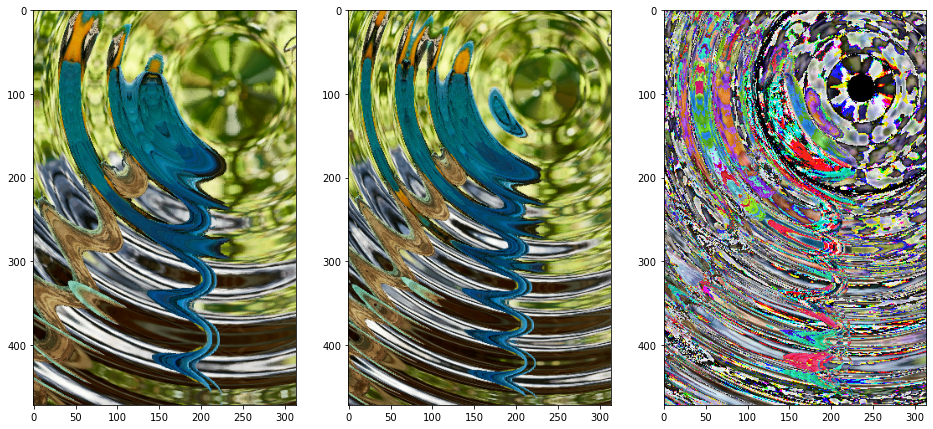

CPU times: total: 16.1 s
Wall time: 17 s


In [14]:
%%time

parrot_raw = io.imread('https://images.unsplash.com/photo-1534567059665-cbcfe2e73b91?q=80&w=1887&auto=format&fit=crop&ixlib='
                   'rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D')

parrot_raw, parrot = resize_and_monochrome (parrot_raw, 6)


xcenter = 0.3 * parrot.shape[1]
ycenter = 0.5 * parrot.shape[0]
distance_coef = 0.5  # Примерное значение для частоты волн
shift = 5 
time = 1 # Сдвиг волн



fig, axes = plt.subplots(1, 3, figsize=(16, 14))
axes[0].imshow(apply_warp_centered(warp_func_centered, parrot_raw, xcenter, ycenter, 
                                             distance_coef, time/2, shift), cmap='gray')
    

    
axes[1].imshow(apply_warp_centered(warp_func_centered, parrot_raw, xcenter, ycenter, 
                                             distance_coef, time, shift/2), cmap='gray')
   

axes[2].imshow(apply_warp_centered(warp_func_centered, parrot_raw, xcenter, ycenter, 
                                             distance_coef, time/2, shift)-apply_warp_centered
               (warp_func_centered, parrot_raw, xcenter, ycenter, 
                                             distance_coef, time, shift/2), cmap='gray')
    
plt.show()

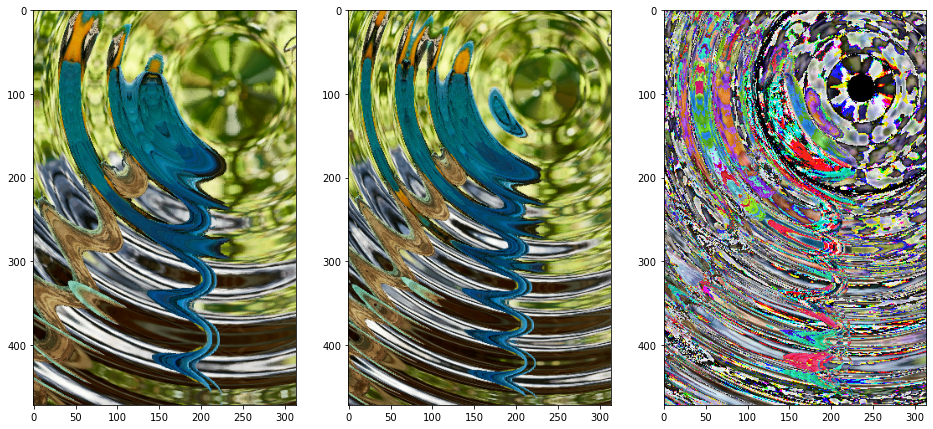

CPU times: total: 16.1 s
Wall time: 17 s


In [15]:
%%time

parrot_raw = io.imread('https://images.unsplash.com/photo-1534567059665-cbcfe2e73b91?q=80&w=1887&auto=format&fit=crop&ixlib='
                   'rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D')

parrot_raw, parrot = resize_and_monochrome (parrot_raw, 6)


xcenter = 0.3 * parrot.shape[1]
ycenter = 0.5 * parrot.shape[0]
distance_coef = 0.5  # Примерное значение для частоты волн
shift = 5 
time = 1 # Сдвиг волн



fig, axes = plt.subplots(1, 3, figsize=(16, 14))
axes[0].imshow(apply_warp_centered(warp_func_centered, parrot_raw, xcenter, ycenter, 
                                             distance_coef, time/2, shift), cmap='gray')
    

    
axes[1].imshow(apply_warp_centered(warp_func_centered, parrot_raw, xcenter, ycenter, 
                                             distance_coef, time, shift/2), cmap='gray')
   

axes[2].imshow(apply_warp_centered(warp_func_centered, parrot_raw, xcenter, ycenter, 
                                             distance_coef, time/2, shift)-apply_warp_centered
               (warp_func_centered, parrot_raw, xcenter, ycenter, 
                                             distance_coef, time, shift/2), cmap='gray')
    
plt.show()

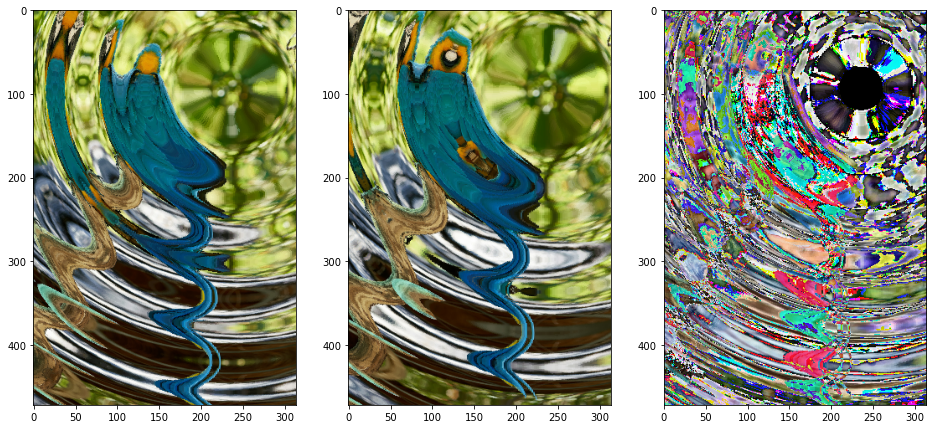

CPU times: total: 15.9 s
Wall time: 16.5 s


In [16]:
%%time

parrot_raw = io.imread('https://images.unsplash.com/photo-1534567059665-cbcfe2e73b91?q=80&w=1887&auto=format&fit=crop&ixlib='
                   'rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D')

parrot_raw, parrot = resize_and_monochrome (parrot_raw, 6)


xcenter = 0.3 * parrot.shape[1]
ycenter = 0.5 * parrot.shape[0]
distance_coef = 0.5  # Примерное значение для частоты волн
shift = 5 
time = 1 # Сдвиг волн


fig, axes = plt.subplots(1, 3, figsize=(16, 14))
axes[0].imshow(apply_warp_centered(warp_func_centered, parrot_raw, xcenter, ycenter, 
                                             distance_coef, time, shift), cmap='gray')
    

    
axes[1].imshow(apply_warp_centered(warp_func_centered, parrot_raw, xcenter, ycenter, 
                                             distance_coef, time*2, shift), cmap='gray')
   

axes[2].imshow(apply_warp_centered(warp_func_centered, parrot_raw, xcenter, ycenter, 
                                             distance_coef, time*2, shift)-apply_warp_centered
               (warp_func_centered, parrot_raw, xcenter, ycenter, 
                                             distance_coef, time, shift), cmap='gray')
    
plt.show()

In [17]:
t2_itogo = tm.time()
print('вся тетрадка заняла', round(t2_itogo - t1_itogo)//60,'минут', round(t2_itogo - t1_itogo)%60,'секунд')

вся тетрадка заняла 2 минут 11 секунд


# Монохромные варианты warp
оставим на всякий случай, фактически не используется

In [18]:
# горизонтальный warp только для монохромного изображения

def warp_horizontal_monochrome(x, y, knob, xsize):
    # Функция clip для ограничения значения n в пределах от 1 до nsize
    def clip(n, nsize):
        return max(min(nsize, n), 1)
    
    # Вычисление новой координаты x с учетом knob
    xnew = clip(x + 10 * ((knob - 16) / 16) * np.sin(y / 4), xsize)
    ynew = y
    return xnew, ynew



def apply_warp_monochrome(warp, A, knob):
    [ysize, xsize] = A.shape # Получение размеров изображения
    
    def linear_interpolation(x_y, xsize, ysize):
        x, y = x_y
        dx = x % 1
        dy = y % 1
        x_left = int(np.floor(x))
        y_left = int(np.floor(y))
        x_right = min(x_left + 1, xsize-1)
        y_right = min(y_left + 1, ysize-1)
        # Вычисление значения нового пикселя через линейную интерполяцию
        return (A[y_left, x_left] * (1 - dx) * (1 - dy) + 
                A[y_right, x_left] * (1 - dx) * dy + 
                A[y_left, x_right] * dx * (1 - dy) + 
                A[y_right, x_right] * dx * dy)
    
    # Создание нового изображения с применением искажения и интерполяции
    result = np.zeros_like(A)
    for x in range(1, xsize + 1):
        for y in range(1, ysize + 1):
            new_x, new_y = warp(x, y, knob, xsize) # Передаем knob и xsize в функцию warp
            # Адаптация координат под нулевую индексацию и запись в result
            result[y - 1, x - 1] = linear_interpolation((new_x - 1, new_y - 1), xsize, ysize)
    
    return result


In [19]:
# круговой warp без динамического преобразования только для монохромного изображения


def warp_func_centered(x, y, xcenter, ycenter, distance_coef, time, shift):
    distance = np.sqrt((xcenter - x) ** 2 + (ycenter - y) ** 2)
    mod_ = 0.25 * np.sin(distance_coef * (distance / (time + shift + 0.1))) + 0.75
    
    def g(center, coord):
        return center + (coord - center) * mod_
    
    xnew = g(xcenter, x)
    ynew = g(ycenter, y)
    
    return xnew, ynew

def apply_warp_centered_monochrome (warp_func, A, xcenter, ycenter, distance_coef,time ,shift):
    xsize, ysize = A.shape
    result = np.zeros_like(A)
    
    for x in range(xsize):
        for y in range(ysize):
            xnew, ynew = warp_func_centered(x + 1, y + 1, xcenter, ycenter, distance_coef, time, shift)
            xnew = int(np.floor(xnew)) - 1
            ynew = int(np.floor(ynew)) - 1
            
            if 0 <= xnew < xsize and 0 <= ynew < ysize:
                result[x, y] = A[xnew, ynew]
    return result
